# **쇼핑몰 주문 데이터 분석 - 코호트 분석**

### **코호트 분석 (Cohort analysis)**
- 코호트란 동질 집단 분석이라고도 부르며, 특정 기간 동안 공통된 특성이나 경험을 갖는 사용집단을 의미
- 코호트 분석은 주로 시간의 흐름에 따라 분석을 진행하고, 사용자 유지, 이탈 패턴이나 세분화된 코호트 간 행동 패턴의 차이점을 분석하여 인사이트를 도출

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data/OnlineRetail2.csv')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceHour,InvoiceWeekday,InvoiceDay,InvoiceMonth,InvoiceYear,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,8,Wednesday,1,12,2010,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,8,Wednesday,1,12,2010,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,8,Wednesday,1,12,2010,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,8,Wednesday,1,12,2010,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,8,Wednesday,1,12,2010,20.34


In [3]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   InvoiceNo       397884 non-null  int64         
 1   StockCode       397884 non-null  object        
 2   Description     397884 non-null  object        
 3   Quantity        397884 non-null  int64         
 4   InvoiceDate     397884 non-null  datetime64[ns]
 5   UnitPrice       397884 non-null  float64       
 6   CustomerID      397884 non-null  int64         
 7   Country         397884 non-null  object        
 8   InvoiceHour     397884 non-null  int64         
 9   InvoiceWeekday  397884 non-null  object        
 10  InvoiceDay      397884 non-null  int64         
 11  InvoiceMonth    397884 non-null  int64         
 12  InvoiceYear     397884 non-null  int64         
 13  Amount          397884 non-null  float64       
dtypes: datetime64[ns](1), float64(2), in

## **우수 고객 판별**

In [5]:
## 매출 상위 10명 고객
pop_amt_customer = data.groupby(['CustomerID']).agg({'Amount':'sum'}).sort_values('Amount', ascending=False).reset_index()
pop_amt_customer.head(10)

,CustomerID,Amount
0,14646,280206.02
1,18102,259657.30
2,17450,194550.79
3,16446,168472.50
4,14911,143825.06
5,12415,124914.53
6,14156,117379.63
7,17511,91062.38
8,16029,81024.84
9,12346,77183.60


In [6]:
## 주문량 상위 10명 고객
pop_qnty_customer = data.groupby(['CustomerID']).agg({'Quantity':'sum'}).sort_values('Quantity', ascending=False).reset_index()
pop_qnty_customer.head(10)

,CustomerID,Quantity
0,14646,196915
1,16446,80997
2,14911,80265
3,12415,77374
4,12346,74215
5,17450,69993
6,17511,64549
7,18102,64124
8,13694,63312
9,14298,58343


## **Retention 분석**

### 1) 사용자 기준 최초 구매 월 계산

In [7]:
import datetime

def get_month_as_datetime(date):
    """구매일의 월초(1일)을 연월일로 돌려준다."""
    return datetime.datetime(date.year, date.month, 1)
data.loc[:, 'Month'] = data['InvoiceDate'].apply(get_month_as_datetime)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceHour,InvoiceWeekday,InvoiceDay,InvoiceMonth,InvoiceYear,Amount,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,8,Wednesday,1,12,2010,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,8,Wednesday,1,12,2010,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,8,Wednesday,1,12,2010,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,8,Wednesday,1,12,2010,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,8,Wednesday,1,12,2010,20.34,2010-12-01


In [8]:
# 사용자별 Month(년월일)
month_group = data.groupby('CustomerID')['Month']
# 월그룹 중 가장 과거 날짜를 MonthStarted 열로 새로 생성지정한다.(최초구매월)
data['MonthStarted'] = month_group.transform(np.min)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceHour,InvoiceWeekday,InvoiceDay,InvoiceMonth,InvoiceYear,Amount,Month,MonthStarted
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,8,Wednesday,1,12,2010,15.30,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,8,Wednesday,1,12,2010,20.34,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,8,Wednesday,1,12,2010,22.00,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,8,Wednesday,1,12,2010,20.34,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,8,Wednesday,1,12,2010,20.34,2010-12-01,2010-12-01


### 2) 기준 월(최초 구매 월)과 실제 구매 월 차이 계산

In [9]:
# 개월수를 구하는 것이기 때문에 연도차에서는 12를 곱해야 1년 차이의 경우 1*12로 12개월이 될 수 있다. 거기에 월차수를 더해준다.
data['MonthPassed'] = (data['Month'].dt.year - data['MonthStarted'].dt.year) * 12 + \
    (data['Month'].dt.month - data['MonthStarted'].dt.month)

### 3) 기준 월, MonthPassed를 기준으로 고객 카운팅

In [10]:
def get_unique_no(x):
    return len(np.unique(x))

cohort_group = data.groupby(['MonthStarted', 'MonthPassed'])
cohort_df = cohort_group['CustomerID'].apply(get_unique_no).reset_index()
cohort_df

,MonthStarted,MonthPassed,CustomerID
0,2010-12-01,0,885
1,2010-12-01,1,324
2,2010-12-01,2,286
3,2010-12-01,3,340
4,2010-12-01,4,321
...,...,...,...
86,2011-10-01,1,86
87,2011-10-01,2,41
88,2011-11-01,0,323
89,2011-11-01,1,36


### 4) 데이터 피벗

In [11]:
cohort_df = cohort_df.pivot(index='MonthStarted', columns='MonthPassed')
cohort_df.head()

CustomerID                                                   \
MonthPassed          0      1      2      3      4      5      6      7    
MonthStarted                                                               
2010-12-01        885.0  324.0  286.0  340.0  321.0  352.0  321.0  309.0   
2011-01-01        417.0   92.0  111.0   96.0  134.0  120.0  103.0  101.0   
2011-02-01        380.0   71.0   71.0  108.0  103.0   94.0   96.0  106.0   
2011-03-01        452.0   68.0  114.0   90.0  101.0   76.0  121.0  104.0   
2011-04-01        300.0   64.0   61.0   63.0   59.0   68.0   65.0   78.0   

                                                 
MonthPassed      8      9      10     11     12  
MonthStarted                                     
2010-12-01    313.0  350.0  331.0  445.0  235.0  
2011-01-01    125.0  136.0  152.0   49.0    NaN  
2011-02-01     94.0  116.0   26.0    NaN    NaN  
2011-03-01    126.0   39.0    NaN    NaN    NaN  
2011-04-01     22.0    NaN    NaN    NaN    NaN

In [12]:
## 백분율 계산
customer_cohort = cohort_df.div(cohort_df.iloc[:, 0], axis=0) * 100
customer_cohort = customer_cohort.round(decimals=2)
customer_cohort

CustomerID                                                   \
MonthPassed          0      1      2      3      4      5      6      7    
MonthStarted                                                               
2010-12-01        100.0  36.61  32.32  38.42  36.27  39.77  36.27  34.92   
2011-01-01        100.0  22.06  26.62  23.02  32.13  28.78  24.70  24.22   
2011-02-01        100.0  18.68  18.68  28.42  27.11  24.74  25.26  27.89   
2011-03-01        100.0  15.04  25.22  19.91  22.35  16.81  26.77  23.01   
2011-04-01        100.0  21.33  20.33  21.00  19.67  22.67  21.67  26.00   
2011-05-01        100.0  19.01  17.25  17.25  20.77  23.24  26.41   9.51   
2011-06-01        100.0  17.36  15.70  26.45  23.14  33.47   9.50    NaN   
2011-07-01        100.0  18.09  20.74  22.34  27.13  11.17    NaN    NaN   
2011-08-01        100.0  20.71  24.85  24.26  12.43    NaN    NaN    NaN   
2011-09-01        100.0  23.41  30.10  11.37    NaN    NaN    NaN    NaN   
2011-10-01        100.0  24.02  11.45    NaN    NaN    NaN    NaN    NaN   
2011-11-01        100.0  11.15    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12-01        100.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                                                 
MonthPassed      8      9      10     11     12  
MonthStarted                                     
2010-12-01    35.37  39.55  37.40  50.28  26.55  
2011-01-01    29.98  32.61  36.45  11.75    NaN  
2011-02-01    24.74  30.53   6.84    NaN    NaN  
2011-03-01    27.88   8.63    NaN    NaN    NaN  
2011-04-01     7.33    NaN    NaN    NaN    NaN  
2011-05-01      NaN    NaN    NaN    NaN    NaN  
2011-06-01      NaN    NaN    NaN    NaN    NaN  
2011-07-01      NaN    NaN    NaN    NaN    NaN  
2011-08-01      NaN    NaN    NaN    NaN    NaN  
2011-09-01      NaN    NaN    NaN    NaN    NaN  
2011-10-01      NaN    NaN    NaN    NaN    NaN  
2011-11-01      NaN    NaN    NaN    NaN    NaN  
2011-12-01      NaN    NaN    NaN    NaN    NaN

### 5) 히트맵 그리기

<AxesSubplot:xlabel='None-MonthPassed', ylabel='MonthStarted'>

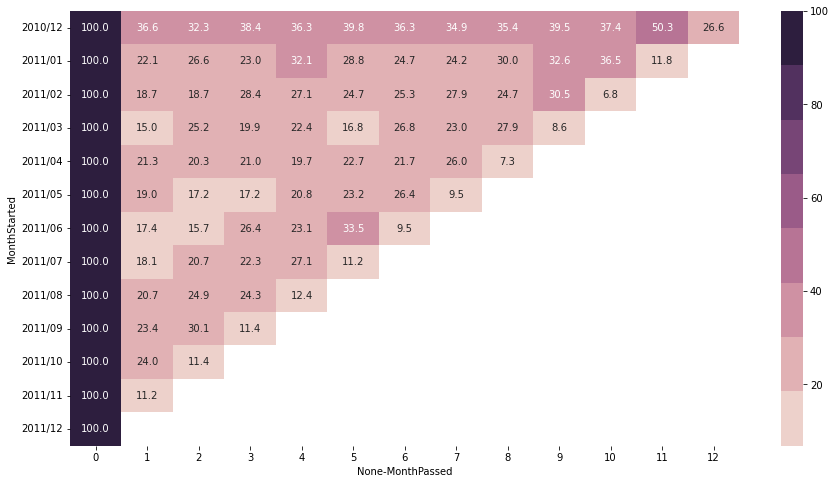

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

xticks = np.arange(0, 13)
yticks = ['2010/12', '2011/01', '2011/02', '2011/03', '2011/04', '2011/05', '2011/06', '2011/07', '2011/08', '2011/09', '2011/10', '2011/11', '2011/12']

plt.figure(figsize = (15, 8))
sns.heatmap(customer_cohort, 
            annot=True, 
            xticklabels=xticks,
            yticklabels=yticks, 
            fmt='.1f',
            cmap=sns.cubehelix_palette(8))

- 구매 후 한 달이 지났을 때 사용자 retention은 평균 30%가 안된다.
- 2010년 12월에 첫 구매를 한 사용자 retention이 가장 높다.
- 2011년 11월에 retention이 대부분 높아졌음을 알 수 있다.